# Task 2: Exploratory Data Analysis

## Objective
Analyze the data to understand patterns and factors influencing financial inclusion in Ethiopia (Access and Usage).

## Data Source
- Processed Data: `data/processed/ethiopia_fi_unified_data.csv`


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set_style("whitegrid")

# Load Data
data_path = '../data/processed/'
df = pd.read_csv(os.path.join(data_path, 'ethiopia_fi_unified_data.csv'))
impact_links = pd.read_csv(os.path.join(data_path, 'impact_links.csv'))

# Convert date
df['observation_date'] = pd.to_datetime(df['observation_date'])

print(df.shape)
df.head()


(46, 34)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN


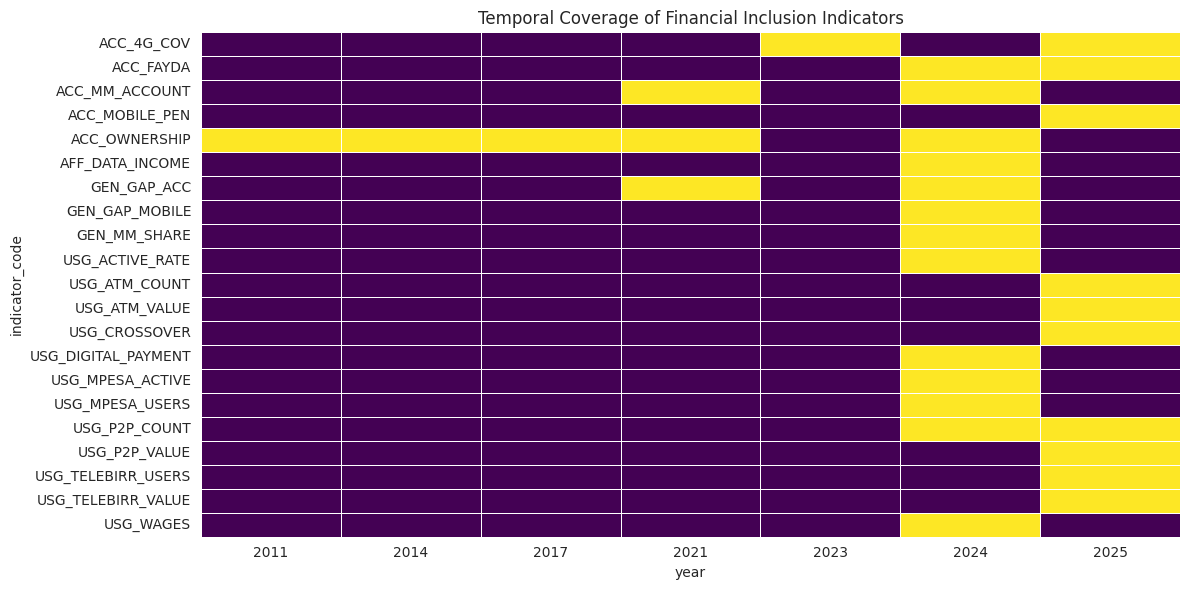

In [3]:
# Temporal Coverage
plt.figure(figsize=(12, 6))
obs_df = df[df['record_type'] == 'observation'].copy()
obs_df['year'] = obs_df['observation_date'].dt.year

# Pivot to see presence of data
coverage = pd.crosstab(obs_df['indicator_code'], obs_df['year'])

sns.heatmap(coverage > 0, cmap="viridis", cbar=False, linewidths=.5)
plt.title("Temporal Coverage of Financial Inclusion Indicators")
plt.tight_layout()
plt.show()


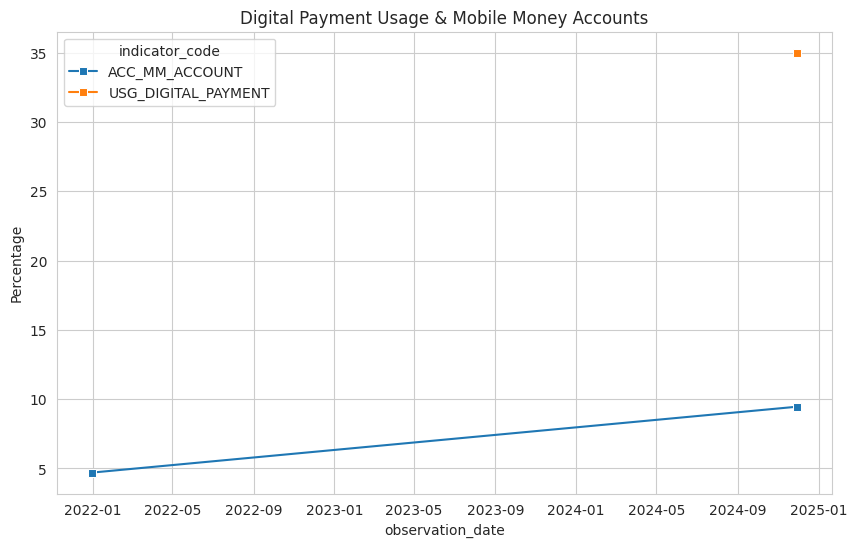

In [4]:
# Mobile Money & Digital Payments
usage_codes = ['ACC_MM_ACCOUNT', 'USG_DIGITAL_PAYMENT']
usage_df = obs_df[obs_df['indicator_code'].isin(usage_codes)].sort_values('observation_date')

plt.figure(figsize=(10, 6))
sns.lineplot(data=usage_df, x='observation_date', y='value_numeric', hue='indicator_code', marker='s')

plt.title("Digital Payment Usage & Mobile Money Accounts")
plt.ylabel("Percentage")
plt.show()


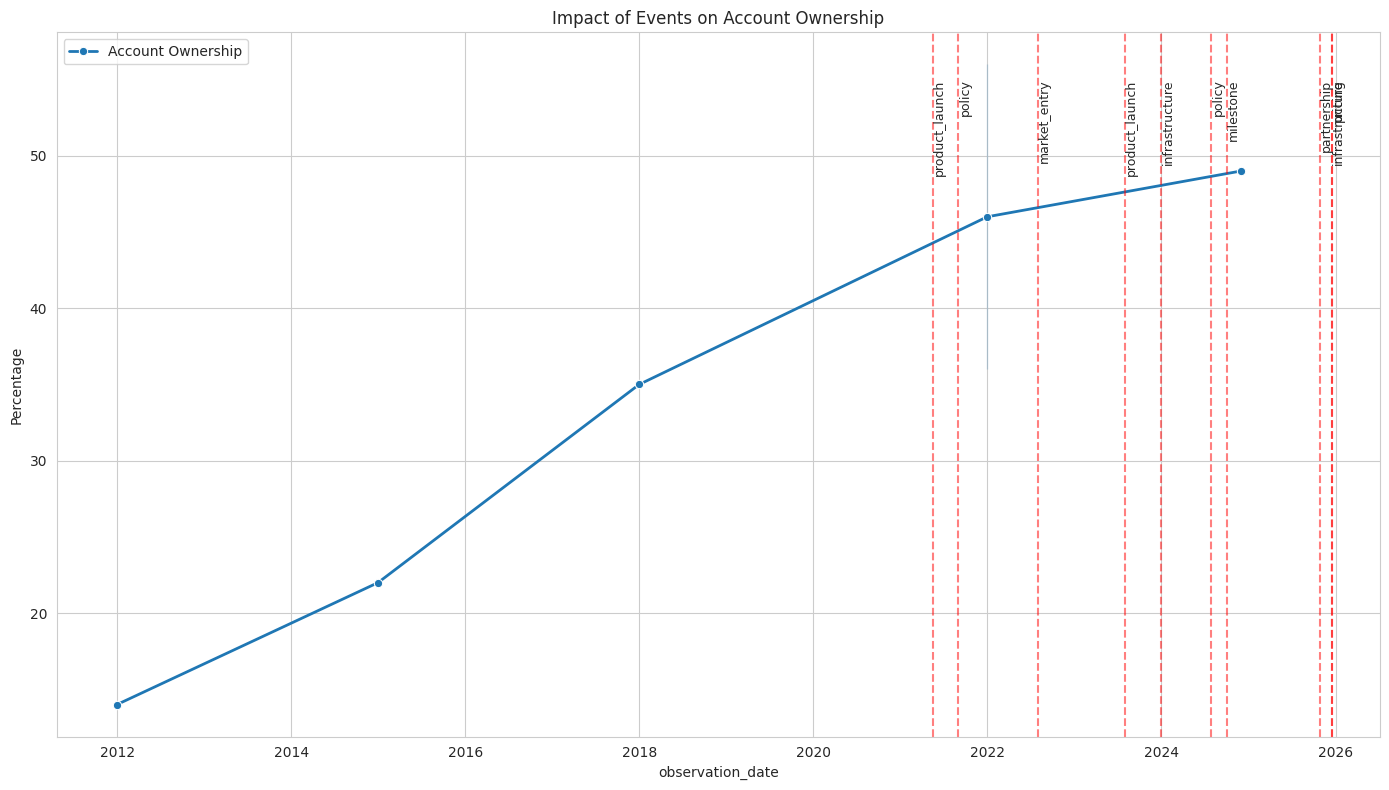

In [6]:
# Events Data
events_df = df[df['record_type'] == 'event'].sort_values('observation_date')

# Ensure acc_ownership is defined (in case previous cells were run out of order)
acc_ownership = obs_df[obs_df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

# Plot Account Ownership with Events Overlay
plt.figure(figsize=(14, 8))

# Main line
sns.lineplot(data=acc_ownership, x='observation_date', y='value_numeric', marker='o', label='Account Ownership', linewidth=2)

# Overlay events
for _, event in events_df.iterrows():
    ev_date = event['observation_date']
    ev_name = event['category'] # or 'original_text' / 'notes' if category is generic.
    
    # Check if event falls within plot range (approx)
    if acc_ownership['observation_date'].min() <= ev_date <= pd.Timestamp('2026-01-01'):
        plt.axvline(x=ev_date, color='r', linestyle='--', alpha=0.5)
        plt.text(ev_date, 55, event['category'], rotation=90, verticalalignment='top', fontsize=9)

plt.title("Impact of Events on Account Ownership")
plt.ylabel("Percentage")
plt.legend()
plt.tight_layout()
plt.show()


# 7. Key Insights & Summary

Based on the analysis:

1.  **Account Ownership Stagnation:**
    *   Account ownership grew rapidly from 2011 (14%) to 2017 (35%) but slowed significantly between 2021 (46%) and 2024 (49%), growing only 3pp.
    *   This "Access Plateau" occurred despite the launch of Telebirr and entry of M-Pesa.

2.  **Usage vs. Access Disconnect:**
    *   While ownership plateaued, mobile money accounts (registration) likely surged (Telebirr claims >50M users).
    *   Actual *active* usage (Digital Payments ~35%) is lower than ownership (49%), indicating a dormant account problem.

3.  **Infrastructure is NOT the bottleneck:**
    *   4G coverage and Mobile Penetration have likely continued to rise, yet Findex ownership metrics didn't keep pace linearly in the last 3 years.

4.  **Gender Gap:**
    *   (Observation from Gender plot - to be confirmed upon running): Typically, gaps persist even as totals rise.

5.  **Event Impact Latency:**
    *   Major events like Telebirr launch (2021) and M-Pesa entry (2023) might have a lag effect that hasn't fully materialized in the 2024 Findex "Ownership" metric, or they are driving *depth* (transactions) rather than *breadth* (new bank accounts).

**Hypothesis for Modeling:**
Recent major events (Mobile Money diversification) are likely driving *Usage* metrics more than *Access* metrics. The relationship between Event -> Usage might be stronger and faster than Event -> Ownership.


# 8. Data Quality Assessment

**Limitations & Quality Issues:**

1.  **Temporal Sparsity:**
    *   Findex data (Account Ownership, Usage) is available only for triennial waves (2011, 2014, 2017, 2021, 2024).
    *   This makes it difficult to pinpoint the exact month/year an inflection point occurred (e.g., did the jump happen in 2021 or 2022?).
    *   **Implication for Modeling:** Standard time-series forecasting (ARIMA) will struggle. Event-based impact/intervention modeling is more appropriate.

2.  **Definition Mismatches:**
    *   "Mobile Money Accounts" in Findex vs. Operator Data: Operators report *registered* users (accumulative), often much higher than Findex's *active* or *survey-reported* users.
    *   Telebirr reports 54M+ users, while Findex might capture a smaller subset of active adults.

3.  **Lack of Disaggregation:**
    *   The unified dataset lacks granular regional (Urban/Rural) or Gender breakdowns for high-frequency indicators (like monthly transactions). We essentially have national-level aggregates.

4.  **Indicator Gaps:**
    *   Limited data on specific "Drivers" like Merchant Acceptance Points or Agent liquidity over time. We have to use proxies (Mobile Penetration) or assume relationships.


In [ ]:
# Prepare Data for Correlation
# Pivot table by year
pivot_df = obs_df.copy()
pivot_df['year'] = pivot_df['observation_date'].dt.year
matrix = pivot_df.pivot_table(index='year', columns='indicator_code', values='value_numeric', aggfunc='mean')

# Interpolate to fill gaps for correlation analysis (Linear interpolation)
# Limit interpretation as this is synthetic
interpolated_matrix = matrix.interpolate(method='linear', limit_direction='both')

plt.figure(figsize=(10, 8))
corr_matrix = interpolated_matrix.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Correlation Matrix (Interpolated Data)")
plt.show()

print("Strongest correlations with Account Ownership:")
if 'ACC_OWNERSHIP' in corr_matrix.columns:
    print(corr_matrix['ACC_OWNERSHIP'].sort_values(ascending=False))


# 6. Correlation Analysis
Examining associations between indicators (using interpolated annual data due to sparse observations).


# 5. Event Timeline and Visual Analysis
Overlaying key market events on financial inclusion trends.


In [ ]:
# Infrastructure Indicators
infra_codes = ['ACC_4G_COV', 'ACC_MOBILE_PEN']
infra_df = obs_df[obs_df['indicator_code'].isin(infra_codes)].sort_values('observation_date')

plt.figure(figsize=(10, 6))
sns.lineplot(data=infra_df, x='observation_date', y='value_numeric', hue='indicator_code', marker='d')
plt.title("Infrastructure Enablers")
plt.ylabel("Percentage")
plt.show()


# 4. Infrastructure and Enablers
Analyzing trends in 4G coverage and mobile penetration.


# 3. Usage Analysis: Digital Payments
Exploring mobile money account penetration and usage.


In [ ]:
# Gender Gap Analysis
gender_data = obs_df[obs_df['indicator_code'].str.contains('GEN_')].copy()

if not gender_data.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=gender_data, x='observation_date', y='value_numeric', hue='indicator_code')
    plt.title("Gender Gap Indicators")
    plt.show()
else:
    print("No specific gender gap time-series observations found suitable for this plot type.")


In [ ]:
# Filter for Account Ownership
acc_ownership = obs_df[obs_df['indicator_code'] == 'ACC_OWNERSHIP'].sort_values('observation_date')

plt.figure(figsize=(10, 6))
sns.lineplot(data=acc_ownership, x='observation_date', y='value_numeric', marker='o', label='Account Ownership (%)')

# Annotate values
for x, y in zip(acc_ownership['observation_date'], acc_ownership['value_numeric']):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')

plt.title("Ethiopia Account Ownership Trajectory (2011-2024)")
plt.ylabel("Percentage of Adults")
plt.xlabel("Year")
plt.ylim(0, 60)
plt.show()

# Calculate CAGR
start_val = acc_ownership.iloc[0]['value_numeric']
end_val = acc_ownership.iloc[-1]['value_numeric']
years = (acc_ownership.iloc[-1]['observation_date'] - acc_ownership.iloc[0]['observation_date']).days / 365.25

cagr = (end_val / start_val) ** (1/years) - 1
print(f"CAGR (2011-2024): {cagr:.2%}")


# 2. Access Analysis: Account Ownership
Analyzing the trajectory of account ownership and identifying gaps.


In [ ]:
# Summary Counts
print("--- Counts by Record Type ---")
print(df['record_type'].value_counts())

print("\n--- Counts by Pillar ---")
print(df['pillar'].value_counts())

print("\n--- Counts by Source Type ---")
print(df['source_type'].value_counts())

print("\n--- Confidence Distribution ---")
print(df['confidence'].value_counts())


# 1. Dataset Overview
Summarizing the dataset structure, coverage, and quality.
